In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
plt.rc('font',family = 'Malgun Gothic')
plt.rc('axes',unicode_minus = False)

import tensorflow as tf


from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import sentencepiece as spm
import unicodedata
import re
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("en-ko.txt",error_bad_lines=False,encoding = 'cp949',header= 0)

b'Skipping line 38: expected 3 fields, saw 4\nSkipping line 40: expected 3 fields, saw 5\nSkipping line 41: expected 3 fields, saw 5\nSkipping line 58: expected 3 fields, saw 4\nSkipping line 63: expected 3 fields, saw 4\nSkipping line 64: expected 3 fields, saw 4\nSkipping line 65: expected 3 fields, saw 5\nSkipping line 66: expected 3 fields, saw 5\nSkipping line 71: expected 3 fields, saw 5\nSkipping line 75: expected 3 fields, saw 5\nSkipping line 80: expected 3 fields, saw 5\nSkipping line 81: expected 3 fields, saw 5\nSkipping line 83: expected 3 fields, saw 5\nSkipping line 86: expected 3 fields, saw 4\nSkipping line 89: expected 3 fields, saw 5\nSkipping line 158: expected 3 fields, saw 5\nSkipping line 203: expected 3 fields, saw 5\nSkipping line 208: expected 3 fields, saw 4\nSkipping line 232: expected 3 fields, saw 5\nSkipping line 233: expected 3 fields, saw 5\nSkipping line 244: expected 3 fields, saw 4\nSkipping line 335: expected 3 fields, saw 5\nSkipping line 336: expe

In [3]:
import urllib3
import zipfile
import shutil
import os
import unicodedata

### 전처리

In [4]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
       if unicodedata.category(c) != 'Mn')

In [5]:
def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    w = re.sub(r"([?.!,])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    w = re.sub(r"[^a-zA-Z[가-힣]?.!]+", " ", w)
    w = re.sub('[-=+,#/\:^$@*\"※~&%ㆍ』\\‘|\(\)\[\]\<\>`\'…》]', '', w)

    w = w.strip()

    w = '<s> ' + w + ' </s>'
    return w

In [6]:
encoder_input, decoder_input = [], []

with open('kor.txt','r',encoding = 'utf-8') as lines:
    for i, line in enumerate(lines):

            # source 데이터와 target 데이터 분리
            src_line, tar_line, _ = line.strip().split('\t')

            # source 데이터 전처리
            src_line_input = [w for w in preprocess_sentence(src_line).split()]

            # target 데이터 전처리
            tar_line_input = [w for w in preprocess_sentence(tar_line).split()]

            encoder_input.append(src_line_input)
            decoder_input.append(tar_line_input)

In [7]:
d  = [' '.join(decoder_input[i]) for i in range(len(decoder_input))]
e = [' '.join(encoder_input[i]) for i in range(len(encoder_input))]

In [8]:
def data_modify(data) :
    df = data.reset_index()
    
    del df['sentences = [']
    
    df = df.iloc[:len(df)-1]
    df.rename(columns = {'level_0' : 'eng','level_1' :'kor'},inplace = True)
    return df

In [9]:
df = data_modify(df)

In [10]:
df['eng'] = [preprocess_sentence(d) for d in df['eng']]
df['kor'] = [preprocess_sentence(d) for d in df['kor']]

In [11]:
d = d[:1500 - len(df)]
e = e[:1500 - len(df)]

In [12]:
new = pd.DataFrame(d,e).reset_index().rename(columns = {'index' : 'eng',0 : 'kor'})

In [13]:
df = pd.concat([df,new]).reset_index()

In [14]:
del df['index']

In [15]:
df.head()

,eng,kor
0,<s> he came to london by way of siberia . </s>,<s> 그 사람은 시베리아를 거쳐서 런던에 와...
1,<s> is there bus service to the airport ? </s>,<s> 공항까지 가는 버스가 있나요 ? </s>
2,<s> japan and south korea are neighbors . </s>,<s> 일본과 남한은 이웃 국가다 . </s>
3,<s> my favorite singer is kylie minogue . </s>,<s> 내가 좋아하는 가수는 카일리 미노그야 ....
4,<s> my favorite singer is kylie minogue . </s>,<s> 내가 좋아하는 가수는 카일리 미노그입ᄂ...


In [16]:
eng_vocab = max(len(l) for l in df['eng']) + 1
kor_vocab = max(len(l) for l in df['kor']) + 1

## SentencePiece

### English

In [17]:
with open('eng_translation.txt','w') as f:
    f.write('\n'.join(df['eng']))

In [18]:
spm.SentencePieceTrainer.Train('--input=eng_translation.txt --model_prefix=english --vocab_size=900 --user_defined_symbols=<s>,</s>')

True

In [19]:
sp_eng = spm.SentencePieceProcessor()
vocab_file = "english.model"
sp_eng.load(vocab_file)

True

In [20]:
print(df['eng'][0])
print(sp_eng.encode_as_pieces(df['eng'][0]))
print(sp_eng.encode_as_ids(df['eng'][0]))

<s> he came to london by way of siberia . </s>
['▁', '<s>', '▁he', '▁came', '▁to', '▁lon', 'don', '▁', 'by', '▁', 'way', '▁of', '▁si', 'ber', 'i', 'a', '▁', '.', '▁', '</s>']
[3, 1, 47, 219, 21, 812, 701, 3, 205, 3, 105, 77, 316, 189, 51, 44, 3, 4, 3, 2]


In [21]:
eng_tokenizer = [sp_eng.encode_as_ids(line) for line in df['eng']]

In [22]:
eng_vocab = pd.read_csv('english.vocab',sep= '\t',header = None)

### Kor

In [23]:
with open('kor_translation.txt','w',encoding = 'utf-8') as f:
    f.write('\n'.join(df['kor']))

In [24]:
df['kor']

0       <s> 그 사람은 시베리아를 거쳐서 런던에 와...
1              <s> 공항까지 가는 버스가 있나요 ? </s>
2             <s> 일본과 남한은 이웃 국가다 . </s>
3       <s> 내가 좋아하는 가수는 카일리 미노그야 ....
4       <s> 내가 좋아하는 가수는 카일리 미노그입ᄂ...
                              ...                        
1495              <s> 톰에게 말을 걸어도 될까 ? </s>
1496                        <s> 고양이 사료 샀어 ? </s>
1497                             <s> 거미 무서워해 ? </s>
1498                <s> 돌고래는 호기심이 많다 . </s>
1499     <s> 거짓말 하지 마세요 . 솔직해지세요 . </s>
Name: kor, Length: 1500, dtype: object

In [25]:
spm.SentencePieceTrainer.Train('--input=kor_translation.txt --model_prefix=kor2 --user_defined_symbols=<s>,</s> --vocab_size=2800 --model_type=bpe')

True

In [26]:
sp_kor = spm.SentencePieceProcessor()
vocab_file = "kor2.model"
sp_kor.load(vocab_file)

True

In [27]:
print(df['kor'][900])
print(sp_kor.encode_as_pieces(df['kor'][900]))
print(sp_kor.encode_as_ids(df['kor'][900]))

<s> 우리가 사과할게 . </s>
['▁', '<s>', '▁우리가', '▁사과', '할게', '▁.', '▁', '</s>']
[2147, 1, 257, 290, 993, 3, 2147, 2]


In [28]:
kor_tokenizer = [sp_kor.encode_as_ids(line) for line in df['kor']]

### padding

In [29]:
eng_tokenizer = pad_sequences(eng_tokenizer,padding = 'post')
kor_tokenizer = pad_sequences(kor_tokenizer,padding = 'post')

In [30]:
print('eng_tokenizer의 크기 : {}'.format(eng_tokenizer.shape))
print('kor_tokenizer의 크기 : {}'.format(kor_tokenizer.shape))

eng_tokenizer의 크기 : (1500, 28)
kor_tokenizer의 크기 : (1500, 21)


In [31]:
indices = np.arange(eng_tokenizer.shape[0])
np.random.shuffle(indices)

In [32]:
encoder_input = eng_tokenizer[indices]
decoder_input = kor_tokenizer[indices]

In [33]:
encoder_train,encoder_test,decoder_train,decoder_test = train_test_split(encoder_input,decoder_input,test_size = 0.2)

In [34]:
print(decoder_train.shape)
print(encoder_train.shape)
print(decoder_test.shape)
print(encoder_test.shape)

(1200, 21)
(1200, 28)
(300, 21)
(300, 28)


## Machine Translation

In [35]:
BUFFER_SIZE = len(encoder_train)
BATCH_SIZE = 64
steps_per_epoch = len(encoder_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = max([max(l) for l in encoder_input])+1
vocab_tar_size = max([max(l) for l in decoder_input])+1

dataset = tf.data.Dataset.from_tensor_slices((encoder_train, decoder_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [36]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 28]), TensorShape([64, 21]))

In [37]:
class Encoder(tf.keras.Model):
      def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
    
      def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state
    
      def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [38]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 28, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [39]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        
        score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))
        
        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [40]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 28, 1)


In [41]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
        
        self.fc = tf.keras.layers.Dense(vocab_size)


        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
   
        context_vector, attention_weights = self.attention(hidden, enc_output)
    
        x = self.embedding(x)

        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        output, state = self.gru(x)

        output = tf.reshape(output, (-1, output.shape[2]))

        x = self.fc(output)

        return x, state, attention_weights

In [42]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 2799)


In [43]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [44]:
@tf.function
def train_step(inp, targ, enc_hidden):
    
    loss = 0
    
    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([sp_kor.piece_to_id('</s>')] * BATCH_SIZE, 1)

        for t in range(1, targ.shape[1]):
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [45]:
EPOCHS = 30

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    
    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  
    
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,total_loss / steps_per_epoch))
    
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.8936
Epoch 1 Loss 2.1038
Time taken for 1 epoch 50.80738544464111 sec

Epoch 2 Batch 0 Loss 1.5313
Epoch 2 Loss 1.5724
Time taken for 1 epoch 34.44798946380615 sec

Epoch 3 Batch 0 Loss 1.3141
Epoch 3 Loss 1.3909
Time taken for 1 epoch 32.98348355293274 sec

Epoch 4 Batch 0 Loss 1.4212
Epoch 4 Loss 1.3077
Time taken for 1 epoch 32.918662309646606 sec

Epoch 5 Batch 0 Loss 1.3069
Epoch 5 Loss 1.2392
Time taken for 1 epoch 32.975563526153564 sec

Epoch 6 Batch 0 Loss 1.2007
Epoch 6 Loss 1.1863
Time taken for 1 epoch 33.33319854736328 sec

Epoch 7 Batch 0 Loss 1.2698
Epoch 7 Loss 1.1406
Time taken for 1 epoch 33.08723568916321 sec

Epoch 8 Batch 0 Loss 1.0089
Epoch 8 Loss 1.0912
Time taken for 1 epoch 32.88547706604004 sec

Epoch 9 Batch 0 Loss 0.9897
Epoch 9 Loss 1.0427
Time taken for 1 epoch 33.304656744003296 sec

Epoch 10 Batch 0 Loss 0.9508
Epoch 10 Loss 0.9919
Time taken for 1 epoch 33.08133363723755 sec

Epoch 11 Batch 0 Loss 0.9349
Epoch 11 Loss 0.9518
Time 

In [46]:
def evaluate(sentence):
    
    max_length_targ = decoder_input.shape[1]
    max_length_inp = encoder_input.shape[1]
    
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = sp_eng.encode_as_ids(sentence)
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([sp_kor.piece_to_id('<s>')], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += sp_kor.decode_ids([int(predicted_id)]) + ' '

        if sp_kor.decode_ids([int(predicted_id)]) == '</s>':
            return result, sentence, attention_plot

    # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [47]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [48]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [55]:
df

,eng,kor
0,<s> he came to london by way of siberia . </s>,<s> 그 사람은 시베리아를 거쳐서 런던에 와...
1,<s> is there bus service to the airport ? </s>,<s> 공항까지 가는 버스가 있나요 ? </s>
2,<s> japan and south korea are neighbors . </s>,<s> 일본과 남한은 이웃 국가다 . </s>
3,<s> my favorite singer is kylie minogue . </s>,<s> 내가 좋아하는 가수는 카일리 미노그야 ....
4,<s> my favorite singer is kylie minogue . </s>,<s> 내가 좋아하는 가수는 카일리 미노그입ᄂ...
...,...,...
1495,<s> could i speak to tom ? </s>,<s> 톰에게 말을 걸어도 될까 ? </s>
1496,<s> did you buy cat food ? </s>,<s> 고양이 사료 샀어 ? </s>
1497,<s> do spiders scare you ? </s>,<s> 거미 무서워해 ? </s>
1498,<s> dolphins are curious . </s>,<s> 돌고래는 호기심이 많다 . </s>


Input: <s> do spiders scare you ? </s>
Predicted translation: <s> 노래하는 거 좋아해 ?  </s> 


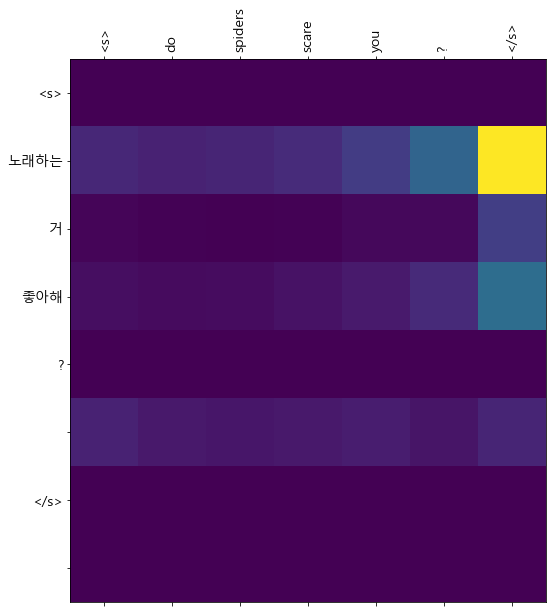

In [59]:
translate(u' do spiders scare you ? ')